# Model 2: Markov-Decision-Process 

This notebook implements the MDP to generate an optimal policy for the BESS. The notebook is structured as follows:

1) Load data, train/val/test split
2) MDP Problem Formulation (theory)
3) MDP Functions
4) Hyperparameter Optimisation Grid search
5) RL model for best hyperparameter set
6) Visualizations

### Imports

In [15]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.patches import Rectangle

import seaborn as sns

### Load Data

In [16]:
df_price = pd.read_excel("data/Price.xlsx")
df_price = df_price[df_price["PriceArea"]=="DK2"].drop(
    columns=["HourUTC"]).rename(
        columns={"HourDK":"Hour"}).reset_index(drop=True)

df_train = df_price.iloc[:int(round(0.70*len(df_price),0))].copy()
df_val = df_price.iloc[int(round(0.70*len(df_price),0)):int(round(0.8*len(df_price),0))].copy()
df_test  = df_price.iloc[int(round(0.8*len(df_price),0)):].copy()
df_train.head()

,Hour,PriceArea,PriceDKK,PriceEUR
0,2021-01-01 00:00:00,DK2,378.519989,50.869999
1,2021-01-01 01:00:00,DK2,358.579987,48.189999
2,2021-01-01 02:00:00,DK2,332.459991,44.680000
3,2021-01-01 03:00:00,DK2,319.369995,42.919998
4,2021-01-01 04:00:00,DK2,300.540009,40.389999


In [17]:
# Extract training prices
train_prices = df_train["PriceDKK"].values
val_prices  = df_val["PriceDKK"].values
test_prices  = df_test["PriceDKK"].values

### MDP Problem Formulation

## 1) Time and System Setup

We consider hourly steps $t = 1,\ldots,T$.

- Battery capacity: $E_{\max} = 400$ MWh  
- Charge/discharge power: $P_{\max} = 100$ MW  
- SOC dynamics:

$E_{t+1} = E_t + P_{\max}$  (charge)  
$E_{t+1} = E_t - P_{\max}$  (discharge)  
$E_{t+1} = E_t$             (idle)

with $0 \le E_t \le E_{\max}$.

## 2) State Space

State components:
- SOC level $i \in \{0,\ldots,4\}$
- Previous-hour price bin $k \in \{1,\ldots,5\}$

State:
$s_t = (i_t, k_{t-1})$

State space:
$S = \{0,\ldots,4\} \times \{1,\ldots,5\}$

## 3) Action Space

Actions:
- $a = 1$: charge  
- $a = 0$: idle  
- $a = -1$: discharge  

Feasibility:
- if $i_t = 0$: no $a = -1$  
- if $i_t = 4$: no $a = 1$  

Thus $A(s)$ is the set of feasible actions.

## 4) Reward Function

Instantaneous reward:

$r_t = \lambda_t \, P_{\max} \, (-a_t)$

Charging gives negative reward, discharging positive.

In the MDP we use price bins.  
Let $\bar{\lambda}(k_t)$ be the representative price of bin $k_t$.

Reward:

$R(s_t,a_t,s_{t+1}) = \bar{\lambda}(k_t)\,P_{\max}\,(-a_t)$

## 5) Transition Probabilities

### SOC transition (deterministic)

$i_{t+1} = i_t + a_t$

$P_{\text{SOC}}(i'|i,a) = 1$ if $i' = i + a$, else $0$.

### Price transition (Markov chain)

$P_{\text{price}}(k'|k) = \frac{N_{k,k'}}{\sum_j N_{k,j}}$

### Full transition

$P((i',k')|(i,k),a) = P_{\text{SOC}}(i'|i,a) \, P_{\text{price}}(k'|k)$

## 6) Discount Factor and Objective

Discount factor:

$\gamma \in (0,1]$ (e.g. $\gamma = 0.99$)

Objective under policy $\pi$:

$J(\pi) = \mathbb{E}_\pi \left[\sum_{t=1}^T \gamma^{t-1} r_t\right]$

## 7) Final MDP Definition

The MDP is  
$M = (S, A, P, R, \gamma)$.

State space:  
$S = \{0,\ldots,4\} \times \{1,\ldots,5\}$

Action space:  
$A(s) \subseteq \{-1,0,1\}$

Transition model:  
$P = P_{\text{SOC}} \cdot P_{\text{price}}$

Reward:  
$R((i,k),a,(i',k')) = \bar{\lambda}(k')\,P_{\max}\,(-a)$

Discount factor:  
$\gamma \in (0,1]$

### MDP Functions

In [18]:
def train_rl_model(num_bins, gamma, df_train):
    """
    Train RL model (MDP + value iteration) on training data only.
    Returns all objects needed for test evaluation.
    """

    train_prices = df_train["PriceDKK"].values

    #  Discretization 
    bin_edges = np.quantile(train_prices, np.linspace(0, 1, num_bins + 1))
    bin_edges[0] -= 1e-6
    df_train_bins = np.clip(np.digitize(train_prices, bin_edges), 1, num_bins)

    #  Price transitions 
    P_price = np.zeros((num_bins, num_bins))
    for t in range(1, len(df_train_bins)):
        k_prev = df_train_bins[t-1] - 1
        k_now  = df_train_bins[t]   - 1
        P_price[k_prev, k_now] += 1

    row_sums = P_price.sum(axis=1, keepdims=True)
    row_sums[row_sums == 0] = 1
    P_price = P_price / row_sums

    #  λ̄(k) 
    lambda_bar = np.zeros(num_bins)
    for k in range(num_bins):
        members = train_prices[df_train_bins == (k + 1)]
        lambda_bar[k] = members.mean() if len(members) > 0 else 0.0

    #  MDP structure 
    SOC_levels = np.arange(5)
    actions = np.array([-1, 0, 1])
    max_soc_index = SOC_levels[-1]
    num_soc = len(SOC_levels)

    # state index
    states = []
    state_to_idx = {}
    for i in range(num_soc):
        for k_prev in range(num_bins):
            idx = len(states)
            states.append((i, k_prev))
            state_to_idx[(i, k_prev)] = idx

    num_states = len(states)
    num_actions = len(actions)

    # feasible actions
    feasible_actions = []
    for (i, k_prev) in states:
        feas = []
        for a in actions:
            if i == 0 and a == -1:
                continue
            if i == max_soc_index and a == 1:
                continue
            feas.append(a)
        feasible_actions.append(feas)

    #  P[s,a,s'] 
    P = np.zeros((num_states, num_actions, num_states))
    for s_idx, (i, k_prev) in enumerate(states):
        for a_idx, a in enumerate(actions):
            if a not in feasible_actions[s_idx]:
                continue
            i_next = i + a
            if i_next < 0 or i_next > max_soc_index:
                continue
            for k_next in range(num_bins):
                prob = P_price[k_prev, k_next]
                if prob > 0:
                    s_next = state_to_idx[(i_next, k_next)]
                    P[s_idx, a_idx, s_next] += prob

    #  Reward 
    P_max = 100.0
    R = np.zeros((num_states, num_actions))
    for s_idx, (i, k_prev) in enumerate(states):
        expected_price = np.dot(P_price[k_prev], lambda_bar)
        for a_idx, a in enumerate(actions):
            if a in feasible_actions[s_idx]:
                R[s_idx, a_idx] = expected_price * P_max * (-a)

    #  Value iteration 
    V = np.zeros(num_states)
    tol = 1e-6
    max_iter = 8000

    for _ in range(max_iter):
        V_old = V.copy()
        for s_idx in range(num_states):
            q_vals = []
            for a_idx, a in enumerate(actions):
                if a not in feasible_actions[s_idx]:
                    continue
                q = R[s_idx, a_idx] + gamma * np.dot(P[s_idx, a_idx], V_old)
                q_vals.append(q)
            V[s_idx] = max(q_vals) if q_vals else 0.0

        if np.max(np.abs(V - V_old)) < tol:
            break

    #  Extract policy 
    policy_idx = np.zeros(num_states, dtype=int)
    for s_idx in range(num_states):
        best_q = -np.inf
        for a_idx, a in enumerate(actions):
            if a not in feasible_actions[s_idx]:
                continue
            q = R[s_idx, a_idx] + gamma * np.dot(P[s_idx, a_idx], V)
            if q > best_q:
                best_q = q
                policy_idx[s_idx] = a_idx

    policy_actions = actions[policy_idx]

    return {
        "bin_edges": bin_edges,
        "P_price": P_price,
        "lambda_bar": lambda_bar,
        "policy_actions": policy_actions,
        "state_to_idx": state_to_idx,
        "num_bins": num_bins,
        "SOC_levels": SOC_levels,
        "actions": actions,
        "V": V,
    }

def evaluate_policy_on_test(model, df_test):
    bin_edges = model["bin_edges"]
    policy_actions = model["policy_actions"]
    state_to_idx = model["state_to_idx"]
    SOC_levels = model["SOC_levels"]
    actions = model["actions"]
    num_bins = model["num_bins"]

    P_max = 100.0
    max_soc_index = SOC_levels[-1]

    # discretize test prices
    df_test_bins = np.clip(
        np.digitize(df_test["PriceDKK"].values, bin_edges),
        1, num_bins
    )

    soc_idx = 0
    prev_price_state = df_test_bins[0] - 1
    total_profit = 0

    for t in range(len(df_test)):
        price = df_test["PriceDKK"].iloc[t]
        price_state = df_test_bins[t] - 1

        s_idx = state_to_idx[(soc_idx, prev_price_state)]
        action = policy_actions[s_idx]

        # enforce feasibility
        if soc_idx == 0 and action == -1:
            action = 0
        if soc_idx == max_soc_index and action == 1:
            action = 0

        total_profit += price * P_max * (-action)

        soc_idx = max(0, min(max_soc_index, soc_idx + action))
        prev_price_state = price_state

    return total_profit

In [19]:
model = train_rl_model(
    num_bins = 5,
    gamma = 0.99,
    df_train = df_train   
)

profit_new_impl = evaluate_policy_on_test(model, df_test)
print("Test profit:", profit_new_impl)

Test profit: 6306996.938199999


### Grid search for best hyperparameter configuration

In [56]:
df_grid

,num_bins,gamma,val_profit
0,3,0.80,0.000000
1,3,0.85,0.000000
2,3,0.90,5.428861
3,3,0.95,23.302113
4,3,0.98,4.719418
...,...,...,...
114,20,0.90,13.626767
115,20,0.95,17.194373
116,20,0.98,21.909789
117,20,0.99,25.367941


In [58]:
results = []

bin_grid = [2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
gamma_grid = [0.8, 0.85,0.90, 0.95, 0.98, 0.99, 1]

for num_bins in bin_grid:
    for gamma in gamma_grid:
        model = train_rl_model(num_bins, gamma, df_train)
        val_profit = evaluate_policy_on_test(model, df_test)
        print(f"bins={num_bins}, gamma={gamma} → val_profit={val_profit:.2f}")
        
        results.append((num_bins, gamma, val_profit))

# Convert to DataFrame
df_grid = pd.DataFrame(results, columns=["num_bins", "gamma", "val_profit"])

df_grid_filtered = df_grid[df_grid["num_bins"] != 2]
best_idx = df_grid_filtered["val_profit"].idxmax()
best_conf = df_grid_filtered.loc[best_idx]

print("")
print("Best configuration:")
print(best_conf)

df_grid["val_profit"] = df_grid["val_profit"]/1e6  # convert to million DKK

bins=2, gamma=0.8 → val_profit=0.00
bins=2, gamma=0.85 → val_profit=0.00
bins=2, gamma=0.9 → val_profit=6789472.01
bins=2, gamma=0.95 → val_profit=27851951.93
bins=2, gamma=0.98 → val_profit=27851951.93
bins=2, gamma=0.99 → val_profit=27851951.93
bins=2, gamma=1 → val_profit=27851951.93
bins=3, gamma=0.8 → val_profit=0.00
bins=3, gamma=0.85 → val_profit=0.00
bins=3, gamma=0.9 → val_profit=5428861.00
bins=3, gamma=0.95 → val_profit=23302112.95
bins=3, gamma=0.98 → val_profit=4719417.94
bins=3, gamma=0.99 → val_profit=4719417.94
bins=3, gamma=1 → val_profit=4719417.94
bins=4, gamma=0.8 → val_profit=0.00
bins=4, gamma=0.85 → val_profit=0.00
bins=4, gamma=0.9 → val_profit=11033249.98
bins=4, gamma=0.95 → val_profit=20682771.03
bins=4, gamma=0.98 → val_profit=16621441.01
bins=4, gamma=0.99 → val_profit=1173336.00
bins=4, gamma=1 → val_profit=1173336.00
bins=5, gamma=0.8 → val_profit=0.00
bins=5, gamma=0.85 → val_profit=0.00
bins=5, gamma=0.9 → val_profit=15873256.99
bins=5, gamma=0.95 → val

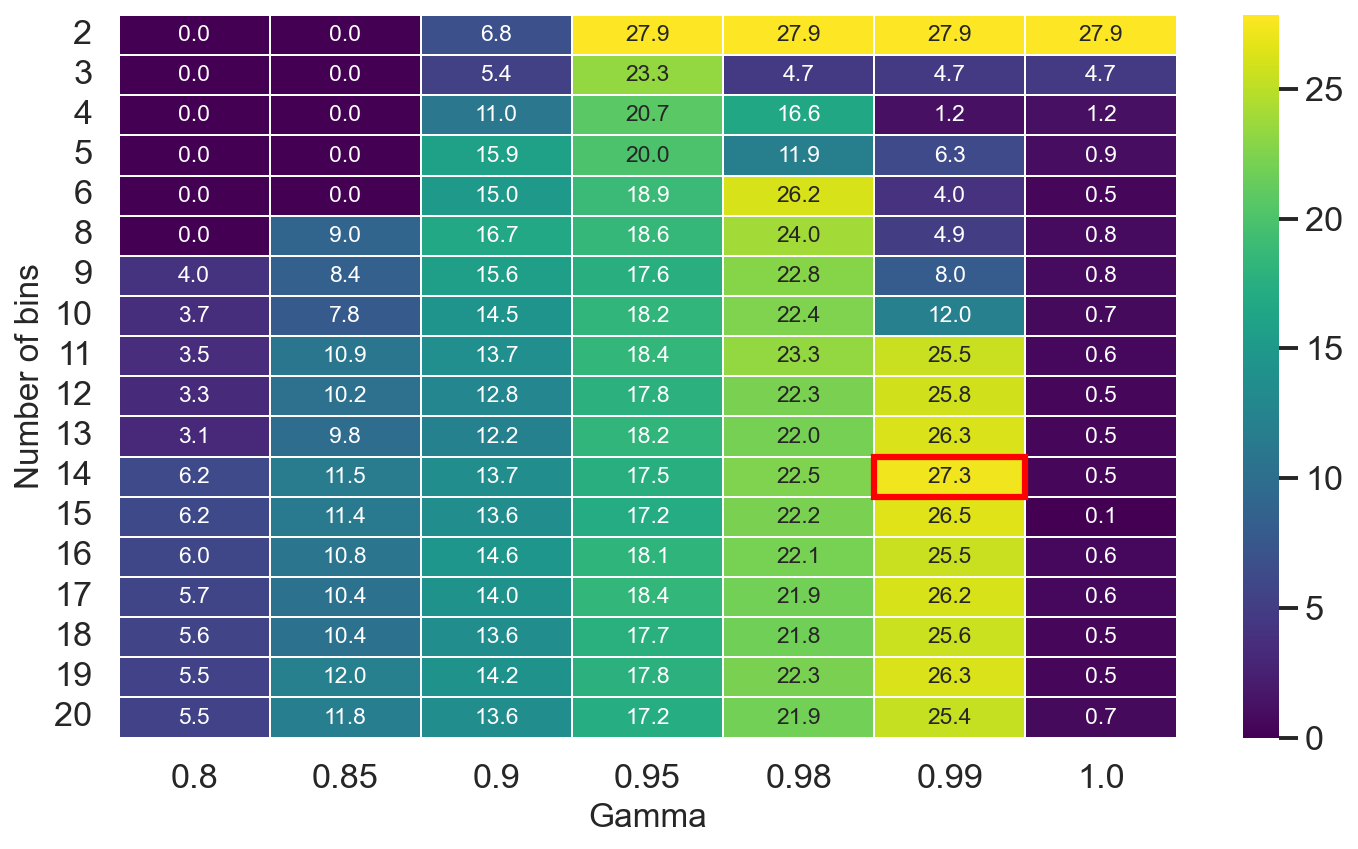

In [59]:
# visualize results as heatmap
pivot = df_grid.pivot(index="num_bins", columns="gamma", values="val_profit")

sns.set_theme(style="white")
plt.rcParams.update({
    "figure.dpi": 150,
    "axes.titlesize": 16,
    "axes.labelsize": 16,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 12,
    "font.family": "sans-serif"
})
sns.set_context("talk", font_scale=1.0)

plt.figure(figsize=(10, 6))
ax = sns.heatmap(
    pivot,
    annot=True,
    fmt=".1f",
    cmap="viridis",
    linewidths=0.8,
    linecolor="white",
    #cbar_kws={"label": "Validation profit (M DKK)"},
    annot_kws={"fontsize": 11}
)

# Title and axis labels
# ax.set_title("Validation profit (M DKK)", pad=12, fontsize=18, fontweight="semibold")
ax.set_ylabel("Number of bins", fontsize=16)
ax.set_xlabel("Gamma", fontsize=16)



# Highlight best configuration 
try:
    best_num = int(best_conf["num_bins"])
    best_gamma = best_conf["gamma"]
    row = pivot.index.get_loc(best_num)
    col = pivot.columns.get_loc(best_gamma)
    rect = Rectangle((col, row), 1, 1, fill=False, edgecolor="red", linewidth=3)
    ax.add_patch(rect)
except Exception:
    pass

plt.tight_layout()
plt.yticks(rotation=0)
plt.show()

### Train best model configuration on train + val data for test evaluation

In [60]:
best_conf.num_bins = int(best_conf.num_bins)
best_conf

/var/folders/v4/lzkm2zzd3gb0q8rqggx5drch0000gn/T/ipykernel_18504/2808272962.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  best_conf.num_bins = int(best_conf.num_bins)


num_bins      1.400000e+01
gamma         9.900000e-01
val_profit    2.730513e+07
Name: 82, dtype: float64

In [61]:
best_conf.gamma

np.float64(0.99)

In [62]:
df_train_final = pd.concat([df_train, df_val], ignore_index=True)
model_final = train_rl_model(
    num_bins = int(best_conf.num_bins),
    gamma    = best_conf.gamma,
    df_train = df_train_final
)

profit_final_test = evaluate_policy_on_test(model_final, df_test)
print("Final optimized RL test-set profit:", profit_final_test/1e6, "M DKK")

Final optimized RL test-set profit: 25.62818389919998 M DKK


## Visualizations

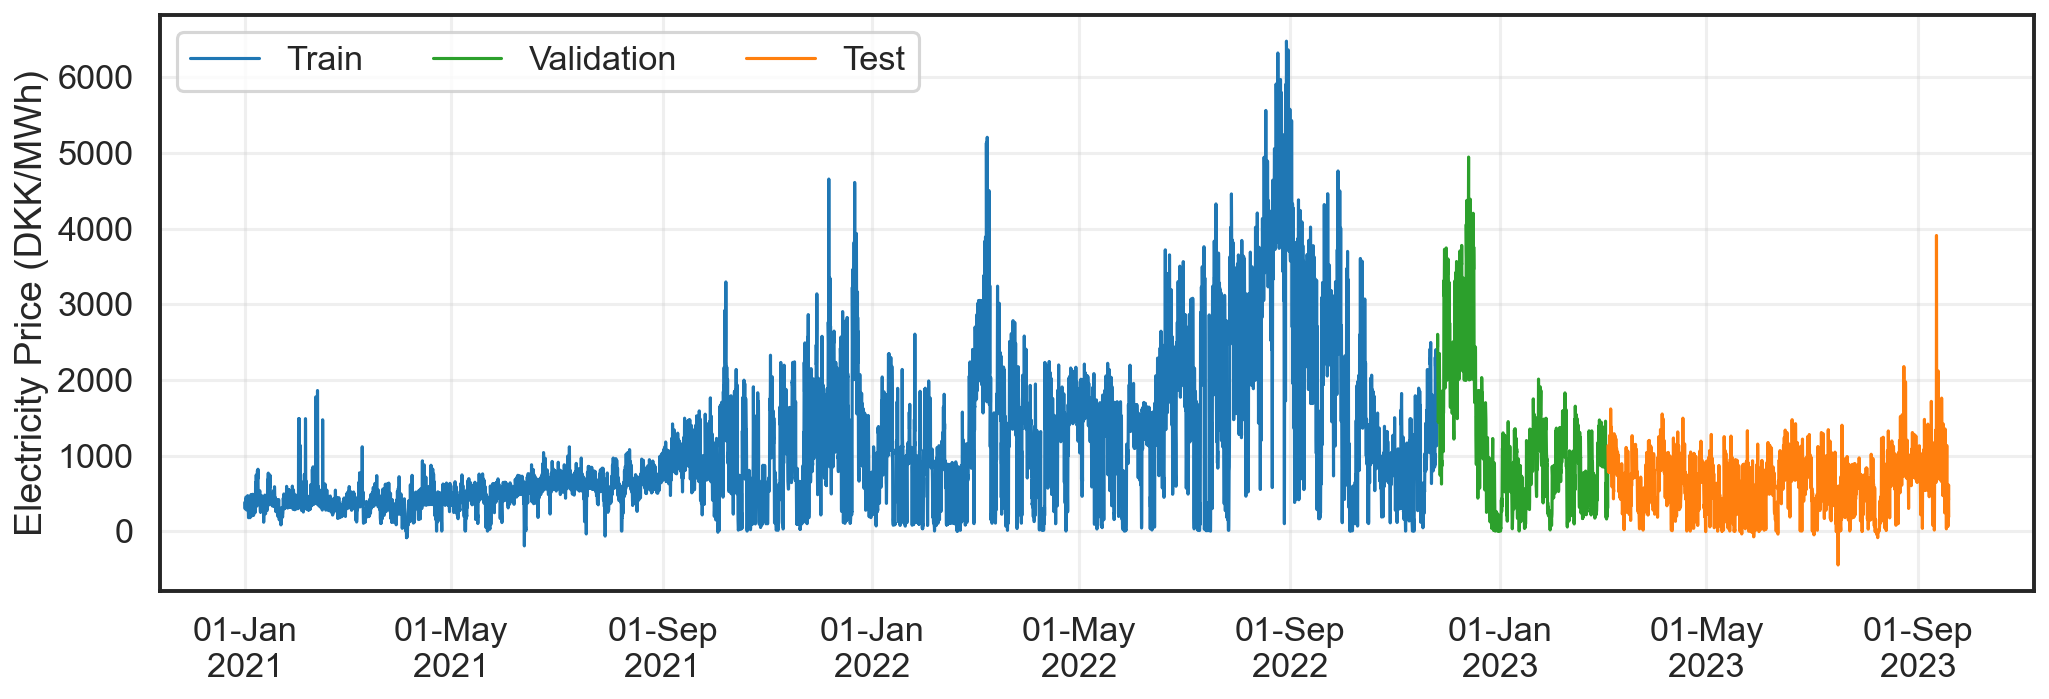

Train samples:      16648
Validation samples:  2378
Test samples:        4757


In [63]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates


# Unified style (same as all other plots)

sns.set_theme(style="white")
plt.rcParams.update({
    "figure.dpi": 150,
    "axes.titlesize": 16,
    "axes.labelsize": 16,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 12,
    "font.family": "sans-serif"
})
sns.set_context("talk", font_scale=1.0)


# Extract segments
# df_train, df_val, df_test are already defined in your notebook

train_series = df_train["PriceDKK"]
val_series   = df_val["PriceDKK"]
test_series  = df_test["PriceDKK"]

time_train = pd.to_datetime(df_train["Hour"])
time_val   = pd.to_datetime(df_val["Hour"])
time_test  = pd.to_datetime(df_test["Hour"])


# Visualization

plt.figure(figsize=(14, 5))
fig = plt.gca()

plt.plot(time_train, train_series, label="Train", color="tab:blue", linewidth=1.5)
plt.plot(time_val,   val_series,   label="Validation", color="tab:green", linewidth=1.5)
plt.plot(time_test,  test_series,  label="Test", color="tab:orange", linewidth=1.5)

# Title + labels
#fig.set_title("Train / Validation / Test Split of Price Data", pad=12, fontsize=18, fontweight="semibold")
#fig.set_xlabel("Time")
fig.set_ylabel("Electricity Price (DKK/MWh)")

# Move the label into the upper-left area
ax.yaxis.set_label_coords(-0.10, 1.02)   # (x, y) in axis coordinates


# X-axis format
fig.xaxis.set_major_formatter(mdates.DateFormatter("%d-%b\n%Y"))

# Grid + legend
plt.grid(True, alpha=0.3)
plt.legend(ncol=3)

plt.tight_layout()
plt.show()

print("Train samples:     ", len(train_series))
print("Validation samples: ", len(val_series))
print("Test samples:       ", len(test_series))

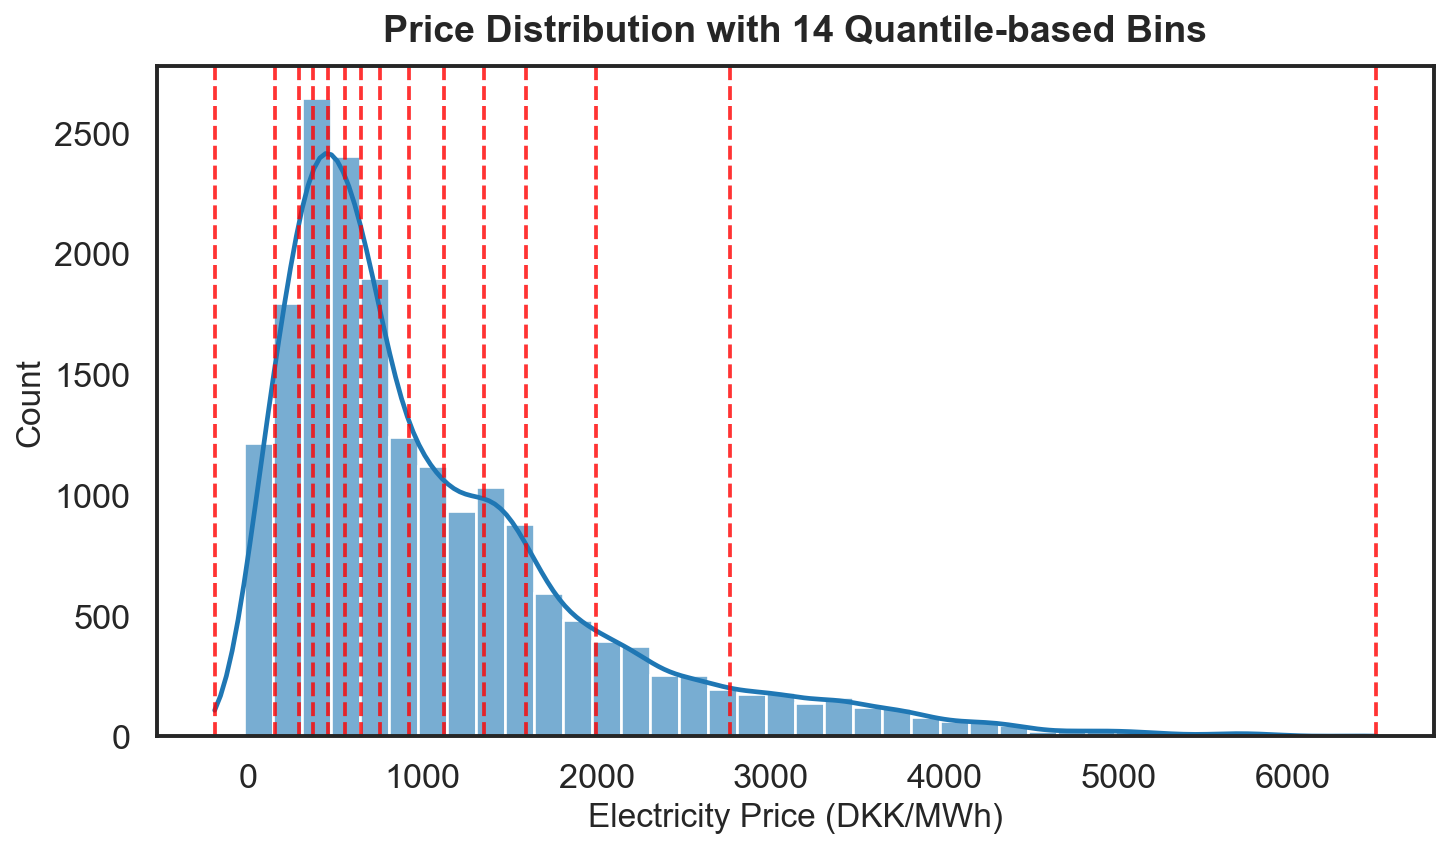

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle


# Style settings (identical to heatmap block)

sns.set_theme(style="white")
plt.rcParams.update({
    "figure.dpi": 150,
    "axes.titlesize": 16,
    "axes.labelsize": 16,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 12,
    "font.family": "sans-serif"
})
sns.set_context("talk", font_scale=1.0)


# Extract final model binning

bin_edges = model_final["bin_edges"]
num_bins  = model_final["num_bins"]
train_prices_all = df_train_final["PriceDKK"].values

# Compute TRAIN+VAL bin assignments (0..num_bins-1)
price_bins_train = np.clip(
    np.digitize(train_prices_all, bin_edges),
    1, num_bins
) - 1

# Representative prices λ̄(k) (optional for debugging)
lambda_bar_vis = []
for b in range(num_bins):
    members = train_prices_all[price_bins_train == b]
    lambda_bar_vis.append(members.mean() if len(members) > 0 else np.nan)
lambda_bar_vis = np.array(lambda_bar_vis)


# Visualization

plt.figure(figsize=(10, 6))

ax = sns.histplot(
    train_prices_all,
    bins=40,
    kde=True,
    color="tab:blue",
    alpha=0.6
)

# Add bin edges as vertical lines
for be in bin_edges:
    plt.axvline(
        be,
        color="red",
        linestyle="--",
        linewidth=1.8,
        alpha=0.8
    )

# Labels & title
ax.set_title(
    f"Price Distribution with {num_bins} Quantile-based Bins",
    pad=12,
    fontsize=18,
    fontweight="semibold"
)
ax.set_xlabel("Electricity Price (DKK/MWh)", fontsize=16)
ax.set_ylabel("Count", fontsize=16)

# Format tick rotation consistent with heatmap
plt.xticks(rotation=0)
plt.yticks(rotation=0)

# Tight layout for clean look
plt.tight_layout()
plt.show()

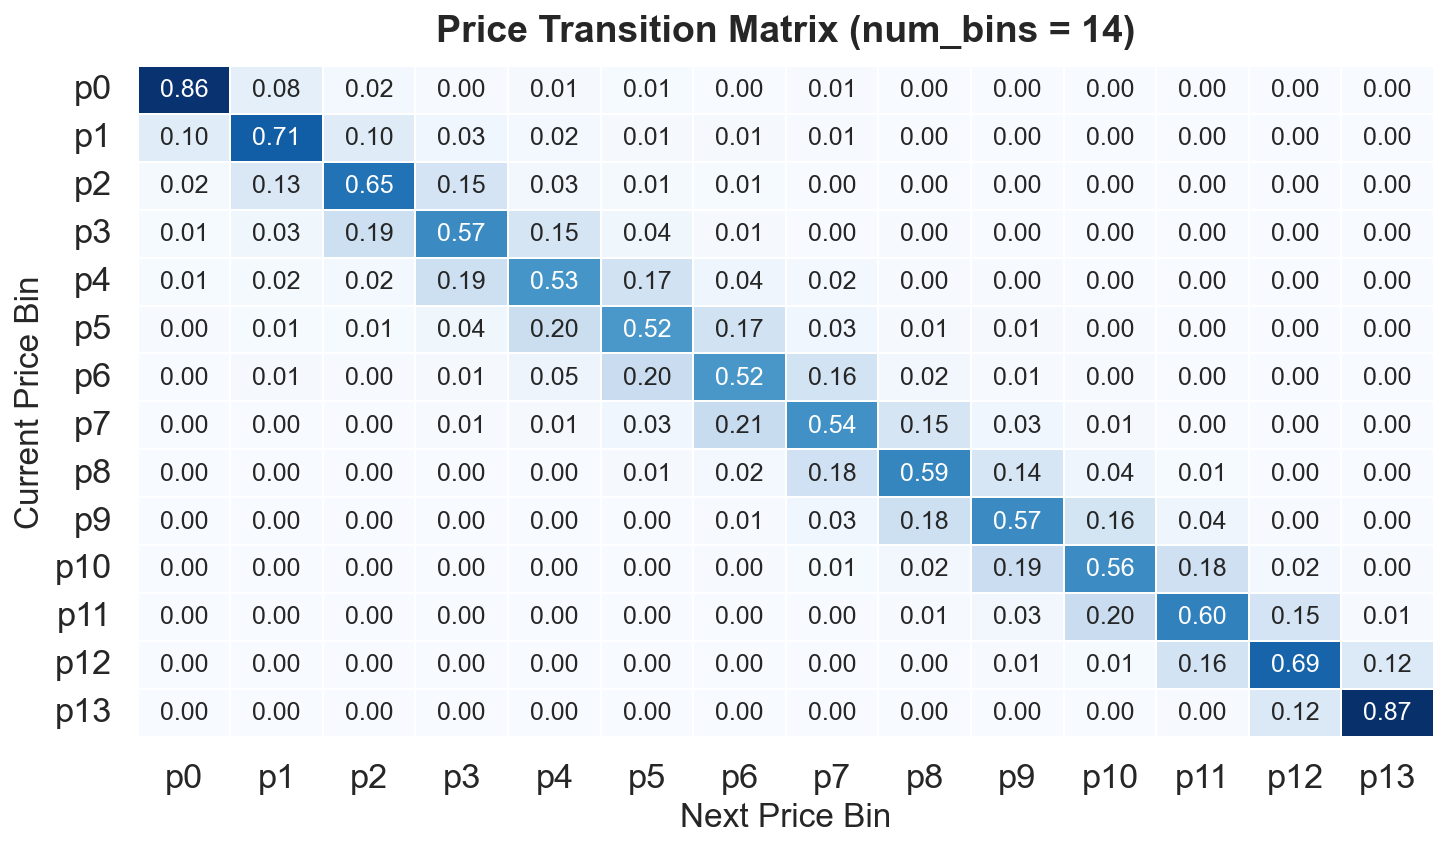

In [65]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# Style settings (identical to hyperparameter heatmap)
sns.set_theme(style="white")
plt.rcParams.update({
    "figure.dpi": 150,
    "axes.titlesize": 16,
    "axes.labelsize": 16,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "font.family": "sans-serif"
})
sns.set_context("talk", font_scale=1.0)


# Recompute price bins using final bin_edges
bin_edges = model_final["bin_edges"]
num_bins  = model_final["num_bins"]

train_prices_all = df_train_final["PriceDKK"].values

# Assign bins: result in 0..num_bins-1
price_bins_all = np.clip(
    np.digitize(train_prices_all, bin_edges),
    1, num_bins
) - 1


# Compute price transition matrix
P_price_mat = np.zeros((num_bins, num_bins))

for t in range(len(price_bins_all) - 1):
    i = price_bins_all[t]
    j = price_bins_all[t+1]
    P_price_mat[i, j] += 1

# Normalize rows
row_sums = P_price_mat.sum(axis=1, keepdims=True)
row_sums[row_sums == 0] = 1
P_price_mat = P_price_mat / row_sums


# Heatmap visualization
plt.figure(figsize=(10, 6))
ax = sns.heatmap(
    P_price_mat,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    linewidths=0.8,
    linecolor="white",
    annot_kws={"fontsize": 12},
    cbar=False
)

ax.set_title(
    f"Price Transition Matrix (num_bins = {num_bins})",
    pad=12,
    fontsize=18,
    fontweight="semibold"
)

ax.set_xlabel("Next Price Bin", fontsize=16)
ax.set_ylabel("Current Price Bin", fontsize=16)

# tick formatting
ax.set_xticks(np.arange(num_bins) + 0.5)
ax.set_xticklabels([f"p{k}" for k in range(num_bins)], rotation=0)

ax.set_yticks(np.arange(num_bins) + 0.5)
ax.set_yticklabels([f"p{k}" for k in range(num_bins)], rotation=0)

plt.tight_layout()
plt.show()

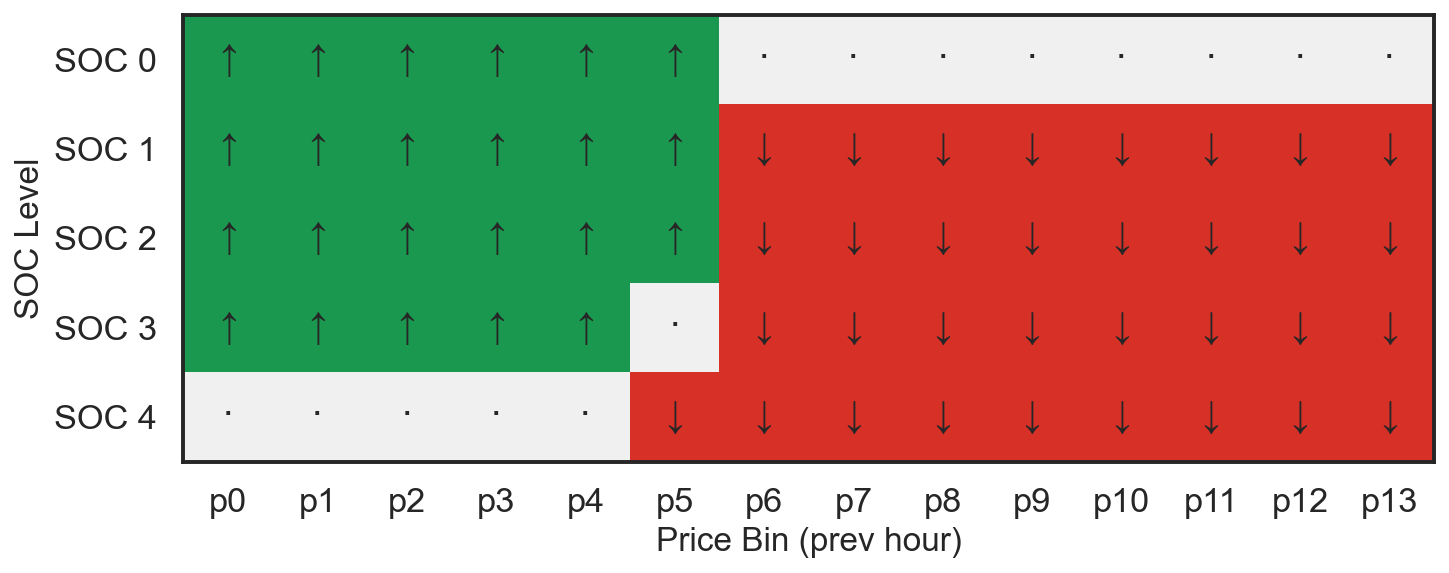

In [66]:
# Style settings (same as hyperparameter heatmap)
sns.set_theme(style="white")
plt.rcParams.update({
    "figure.dpi": 150,
    "axes.titlesize": 16,
    "axes.labelsize": 16,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "font.family": "sans-serif"
})
sns.set_context("talk", font_scale=1.0)


# Load model objects
policy_actions = model_final["policy_actions"]
state_to_idx   = model_final["state_to_idx"]
num_bins       = model_final["num_bins"]
SOC_levels     = model_final["SOC_levels"]

num_soc = len(SOC_levels)

# Build policy matrix
policy_matrix_final = np.zeros((num_soc, num_bins), dtype=int)
for i in range(num_soc):
    for k_prev in range(num_bins):
        s_idx = state_to_idx[(i, k_prev)]
        policy_matrix_final[i, k_prev] = policy_actions[s_idx]

# Colormap for background colors
cmap = ListedColormap(["#d73027", "#f0f0f0", "#1a9850"])  # red, grey, green
bounds = [-1.5, -0.5, 0.5, 1.5]
norm = BoundaryNorm(bounds, cmap.N)


# Plot without colorbar

plt.figure(figsize=(10, 6))
ax = plt.gca()

ax.imshow(policy_matrix_final, cmap=cmap, norm=norm)

# Add arrows (unchanged)
for i in range(num_soc):
    for k in range(num_bins):
        a = policy_matrix_final[i, k]
        symbol = "↓" if a == -1 else ("·" if a == 0 else "↑")
        ax.text(k, i, symbol, ha='center', va='center', fontsize=18)

# Labels & title
# ax.set_title(
#     "Optimal RL Policy (Best Hyperparameters)",
#     pad=12,
#     fontsize=18,
#     fontweight="semibold"
# )
ax.set_xlabel("Price Bin (prev hour)", fontsize=16)
ax.set_ylabel("SOC Level", fontsize=16)

# Ticks
ax.set_xticks(range(num_bins))
ax.set_xticklabels([f"p{k}" for k in range(num_bins)], rotation=0)

ax.set_yticks(range(num_soc))
ax.set_yticklabels([f"SOC {i}" for i in range(num_soc)], rotation=0)

plt.tight_layout()
plt.show()